# Ants and Bees - Classification to Demonstrate Transfer Learning

- This notebook is supposed to be an amateur's first foray into Transfer Learning.
- It operates on a dataset that is relatively small - with 120 images for ants and bees. There are 75 validation images for each class as well.
- Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

## Downloading the Data

In [1]:
from io import BytesIO
from typing import Union
from zipfile import ZipFile
import requests
from os import path, rename


"""Downloads a zip file from `url`, extracts it at `dest`, renames the extracted folder to `new_dir_name`."""


def download_zip_and_extract(url: str, dest: str, new_dir_name: Union[str, None] = None):
  file_name = ".".join(url.split('/')[-1].split('.')[:-1])
  dest_path = path.join(path.curdir, dest)

  if path.exists(path.join(dest_path, new_dir_name if new_dir_name else file_name)):
    print("Destination folder already exists")
    return


  print("Downloading started")
  req=requests.get(url)
  print("Downloading completed. Extraction started")

  zipfile=ZipFile(BytesIO(req.content))
  zipfile.extractall(dest_path)

  print("Extraction completed")

  if new_dir_name:
    rename(path.join(dest_path, file_name), new_dir_name)


In [2]:
DATA_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_dest = "."
download_zip_and_extract(DATA_URL, data_dest, "data")

Destination folder already exists


### Relevant Imports

In [3]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, transforms as T, models
import matplotlib.pyplot as plt
import time
import os

plt.ion()

### Load Data

In [4]:
data_transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
batch_size = 4

In [6]:
data_dir = path.join(data_dest, "data")

image_datasets = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(
    True if x == 'train' else False), num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
category_names = image_datasets['train'].classes


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Visualising a Few Images

- We'll plot a few images to see the effects of the data transforms.

In [25]:
from torch import Tensor


def imshow(inp: Tensor, title=None):
  """Plot image if `inp` is a tensor"""

  inp = inp.cpu().numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  inp = std * inp + mean
  np.clip(inp, 0, 1)

  if title is not None:
    plt.title(title)

  return plt.imshow(inp)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


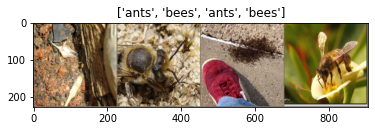

In [27]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, [category_names[x] for x in classes])


### Training the Model

It will help us to:
  - schedule the learning rate
  - saving the best model

In [10]:
from copy import deepcopy
from torch.nn import Module


def train_model(model: Module, criterion, optimizer: optim.Optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f"Epoch: {epoch} / {num_epochs}")

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()

      else:
        model.eval()

      running_loss, running_corrects = 0.0, 0

      for inputs, labels in dataloaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero all the layers' parameters gradients
        optimizer.zero_grad()

        # feed forward
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, dim=1)
          loss = criterion(outputs, labels)

          # backpropagate loss only if training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # default loss item is mean, therefore we multiply it with the number of items in the batch
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print(
      f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  model.load_state_dict(best_model_wts)
  return model


### Visualising Model Predictions

In [32]:
from matplotlib.image import AxesImage


def process_tensor_to_display(inp: Tensor) -> np.ndarray:
  inp = inp.cpu().numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  inp = std * inp + mean
  np.clip(inp, 0, 1)

  return inp


In [37]:
def visualise_predictions(model: Module, num_images: int, n_rows: int, n_cols: int):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig, ax = plt.subplots(n_rows, n_cols)

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)

      for j in range(inputs.size(0)):

        # below call takes number of rows, number of cols, index of item that starts at 1
        plotX, plotY = images_so_far // n_cols, images_so_far % n_cols
        ax[plotX, plotY].imshow(process_tensor_to_display(inputs[j].detach()))
        ax[plotX, plotY].axis('off')
        ax[plotX, plotY].set_title(f"Predicted {category_names[preds[j]]}")
        images_so_far += 1

        # imshow(inputs[j].detach())

        if images_so_far == num_images:
          model.train(was_training)
          return

  model.train(was_training)


### Finetuning the convnet

Load a pretrained model and reset final fully connected layer

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(category_names))

model_ft = model_ft.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch: 0 / 30


d:\ProgramFiles\anaconda\envs\fastapi-ml\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5452 Acc: 0.6844

val Loss: 0.2099 Acc: 0.9216

Epoch: 1 / 30
train Loss: 0.4097 Acc: 0.8279

val Loss: 0.2839 Acc: 0.8824

Epoch: 2 / 30
train Loss: 0.5586 Acc: 0.7746

val Loss: 0.3774 Acc: 0.8366

Epoch: 3 / 30
train Loss: 0.5762 Acc: 0.7418

val Loss: 0.2786 Acc: 0.8889

Epoch: 4 / 30
train Loss: 0.4245 Acc: 0.8033

val Loss: 0.3033 Acc: 0.8889

Epoch: 5 / 30
train Loss: 0.5666 Acc: 0.7746

val Loss: 0.3868 Acc: 0.8497

Epoch: 6 / 30
train Loss: 0.3811 Acc: 0.8648

val Loss: 0.3813 Acc: 0.8889

Epoch: 7 / 30
train Loss: 0.4489 Acc: 0.7951

val Loss: 0.2856 Acc: 0.9150

Epoch: 8 / 30
train Loss: 0.3303 Acc: 0.8525

val Loss: 0.2610 Acc: 0.9281

Epoch: 9 / 30
train Loss: 0.4298 Acc: 0.8361

val Loss: 0.2819 Acc: 0.9020

Epoch: 10 / 30
train Loss: 0.3481 Acc: 0.8320

val Loss: 0.2554 Acc: 0.9216

Epoch: 11 / 30
train Loss: 0.2995 Acc: 0.8852

val Loss: 0.2408 Acc: 0.9281

Epoch: 12 / 30
train Loss: 0.3145 Acc: 0.8566

val Loss: 0.2455 Acc: 0.9216

Epoch: 13 / 30
train Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


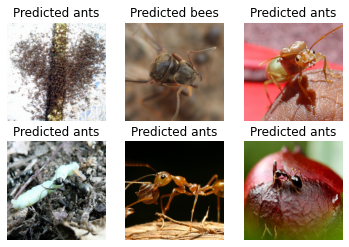

In [38]:
visualise_predictions(model_ft, 6, 2, 3)